In [1]:
#conda install -c conda-forge pydotplus00
#conda install -c gafortiby sklearn-pandas 

%matplotlib inline

In [2]:
import numpy as np

random_seed = 123
np.random.seed(random_seed)

# 1. Building a decision tree

<img src="tech.png" alt="drawing" width="200"/>

A multi-channel electroencephalography (EEG) system enables a broad range of applications including neurotherapy, biofeedback, and brain computer interfacing. It has 14 EEG channels with names based on the International 10-20 locations: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4:

<img src="EEG.png" alt="drawing" width="200"/>

The dataset you will analyse is created with the [Emotiv EPOC+](https://www.emotiv.com/product/emotiv-epoc-14-channel-mobile-eeg). All data is from one continuous EEG measurement with the Emotiv EEG Neuroheadset. The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measurement and later added manually to the file after analyzing the video frames. A '1' indicates the eye-closed and '0' the eye-open state.(*Source: Oliver Roesler, Stuttgart, Germany*)

We start by loading the Pandas library and reading the train set file into a Pandas DataFrame called `train`.

In [3]:
import pandas as pd

train = pd.read_csv("train.csv")

Load the test set file into a Pandas DataFrame called `test`. 

In [4]:
#solution
test = pd.read_csv("test.csv")

Let's look at the first 5 rows of the train set.

In [5]:
train.head(5)

,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4231.79,4047.18,4229.23,4137.44,4334.36,4612.82,4054.36,4579.49,4170.26,4198.97,4131.79,4226.15,4509.23,4264.10,0
1,4287.69,3989.23,4249.74,4120.51,4340.51,4616.92,4049.23,4615.38,4214.36,4234.36,4209.74,4275.38,4605.64,4339.49,0
2,4353.85,4055.90,4336.41,4155.90,4371.28,4663.08,4108.72,4653.33,4227.18,4268.72,4252.31,4315.38,4657.44,4417.95,0
3,4258.46,4002.05,4248.21,4118.97,4331.28,4626.67,4068.72,4591.28,4180.00,4214.36,4179.49,4260.51,4578.46,4320.51,0
4,4294.87,4005.64,4267.69,4120.51,4338.46,4617.44,4057.95,4601.54,4180.51,4219.49,4168.21,4275.90,4596.41,4349.74,1


We see 14 columns that each correspond to the measurements of one EEG channel. Each row is a time-point. The column `eyeDetection` annotates each time-point with '1' when the eye was recorded as closed and '0' when the eye was recorded as open.  

Our goal is to build a predictive model from the train set that is able to accuratly predict the eye states in the test set from the 14 channel measurements. 

Show the last 10 rows of the test set:

In [6]:
#solution
test.tail(10)

,index,AF3,F7,F3,FC5,T7,P7,O1,02,P8,T8,FC6,F4,F8,AF4
4970,4970,4302.56,4060.00,4271.28,4135.90,4356.41,4633.85,4074.87,4613.85,4209.23,4232.31,4198.97,4283.59,4618.97,4358.46
4971,4971,4273.85,3975.38,4252.82,4106.67,4331.28,4604.10,4042.05,4608.21,4187.18,4227.18,4209.74,4263.59,4593.85,4346.67
4972,4972,4283.59,4030.77,4267.18,4130.77,4342.05,4611.79,4038.97,4605.64,4190.77,4228.21,4202.05,4273.85,4618.97,4344.62
4973,4973,4278.46,3978.46,4247.18,4106.67,4329.74,4596.41,4035.90,4614.36,4201.54,4225.13,4217.95,4273.85,4601.54,4348.72
4974,4974,4278.46,4001.54,4242.56,4120.51,4324.10,4607.18,4061.03,4594.36,4191.28,4207.69,4177.95,4257.95,4582.05,4343.08
4975,4975,4335.90,3981.03,4255.38,4122.05,4348.21,4612.31,4073.85,4600.00,4187.69,4234.36,4205.13,4283.59,4604.62,4388.72
4976,4976,4317.44,4034.87,4281.03,4155.90,4369.23,4642.56,4104.62,4674.87,4223.59,4253.33,4231.28,4293.33,4629.23,4368.21
4977,4977,4317.44,4021.54,4275.90,4126.15,4367.18,4628.72,4093.85,4624.62,4203.59,4248.21,4227.18,4292.31,4626.15,4398.46
4978,4978,4250.77,4014.87,4220.00,4108.21,4344.62,4608.21,4062.05,4609.23,4176.92,4217.95,4181.03,4253.85,4557.44,4314.87
4979,4979,4332.31,4034.36,4297.95,4138.97,4360.51,4641.54,4077.95,4628.72,4202.56,4246.67,4230.26,4298.97,4625.13,4388.21


This is a blind test so the `eyeDetection` column is not available in the test set. The test set does contain a column called `index` that you will need to send your predictions to the Kaggle website.

Let's look at the shape of the train and test set:

In [7]:
print(train.shape)
print(test.shape)

(10000, 15)
(4980, 15)


How many time-points does the test set contain?

We can get some general statistics about the train set using the DataFrame `.describe()` function:

In [8]:
#data.astype('object').describe().transpose()
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AF3,10000.0,4332.092934,3049.686671,4197.95,4280.51,4293.85,4311.79,309231.00
F7,10000.0,4009.310593,35.609081,2830.77,3990.26,4005.64,4023.08,5500.51
F3,10000.0,4264.054266,38.193985,2457.44,4250.26,4262.56,4270.77,6880.51
FC5,10000.0,4186.133845,6384.464028,4058.46,4108.21,4120.51,4131.79,642564.00
T7,10000.0,4341.806736,29.420133,4304.62,4331.79,4338.97,4346.67,6474.36
P7,10000.0,4620.233513,39.778819,4002.05,4611.79,4617.95,4626.15,8092.31
O1,10000.0,4128.806712,5631.138585,2086.15,4057.95,4070.26,4083.59,567179.00
02,10000.0,4615.799573,18.893825,4567.69,4604.62,4613.33,4624.10,5087.69
P8,10000.0,4227.690358,2614.621005,4153.85,4190.77,4199.49,4209.23,265641.00
T8,10000.0,4230.877726,31.398484,1816.41,4220.51,4229.23,4239.49,4362.56


The scikit-learn `DecisionTreeClassifier` class computes a decision tree predictive model from a data set. To get all the options for learning you can simply type: 

In [9]:
from sklearn.tree import DecisionTreeClassifier
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree.tree:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.

Let's create a decision tree model:

In [10]:
cls_DT = DecisionTreeClassifier()

This creates a decision tree model with default values for the hyperparameters:

In [11]:
cls_DT

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

To fit the train set we need to have our features and labels in different DataFrames. I call them `X` and `y`:

In [12]:
X = train.sample(frac=1).copy()
y = X.pop("eyeDetection")

print(X.shape)
print(y.shape)

(10000, 14)
(10000,)


Now we can fit the train set in just one line of code:

In [13]:
cls_DT.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Let's see how well the decision tree performs on the train set:

In [14]:
from sklearn.metrics import accuracy_score

predictions = cls_DT.predict(X)
print("Accuracy: %f"%(accuracy_score(predictions, y)))

Accuracy: 1.000000


Great! With just a few lines of code a get perfect accuracy on my data set!

These are the predictions for the first 20 data points:

In [15]:
predictions[0:20]

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1],
      dtype=int64)

The following code plots the fitted decision tree `cls` as a `tree.png` file:

In [16]:
from sklearn import tree
from io import StringIO
from IPython.display import Image, display
import pydotplus

out = StringIO()
tree.export_graphviz(cls_DT, out_file=out)
graph=pydotplus.graph_from_dot_data(out.getvalue())
graph.write_png("tree.png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.627756 to fit



True

# 2. Kaggle evaluation

Let's make a Kaggle submission:

In [17]:
#code for submission
index_col = test.pop("index")
predictions_test = cls_DT.predict(test)
out_tmp = pd.DataFrame()
out_tmp["index"] = index_col
out_tmp["eyeDetection"] = predictions_test
out_tmp.to_csv("submission.csv",index=False)

# 3. The test set

Since we don't have the test set `eyeDetection` labels we cannot check overfitting on the test set before submitting our predictions. So we need to create our own test set (**not seen during training!**) with known class labels.

Scikit-learn offers many options to do this. One of them is the `train_test_split` function:

In [18]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X,y,test_size=.2, random_state=random_seed)

#train fold
print(train_X.shape)
print(train_y.shape)
#validation fold
print(val_X.shape)
print(val_y.shape)

(8000, 14)
(8000,)
(2000, 14)
(2000,)


Fit a decision tree model with default paramters on the `train_X` data set.

In [19]:
#solution
cls_DT = DecisionTreeClassifier()
cls_DT.fit(train_X,train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

What is the accuracy on `train_X`? 

In [20]:
#solution
predictions = cls_DT.predict(train_X)
print("Accuracy: %f"%(accuracy_score(predictions, train_y)))

Accuracy: 1.000000


What is the accuracy on `val_X`?

In [21]:
#solution
predictions = cls_DT.predict(val_X)
print("Accuracy: %f"%(accuracy_score(predictions, val_y)))

Accuracy: 0.808000


What do you see?


# 4. Hyperparameters

Let's look at the  `DecisionTreeClassifier` again.

In [22]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree.tree:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.

Notice that there are many parameters (**hyperparameters**) that influence the contruction of a decision tree. One of them is `max_depth` that limits the depth of the contructed decicison tree. The following code evaluates different values for this hyperparameter.

In [23]:
for maxdepth in range(3,24,1):
    cls = DecisionTreeClassifier(max_depth=maxdepth)
    cls.fit(train_X,train_y)
    predictions_train = cls.predict(train_X)
    predictions_val = cls.predict(val_X)
    print("%i %f %f"%(maxdepth,accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

3 0.677875 0.668000
4 0.715250 0.705000
5 0.734125 0.712000
6 0.755125 0.733500
7 0.784625 0.753000
8 0.808125 0.766000
9 0.845750 0.788000
10 0.873875 0.807500
11 0.898500 0.819500
12 0.918625 0.815500
13 0.938250 0.809000
14 0.955875 0.804000
15 0.970250 0.804500
16 0.981250 0.813500
17 0.989250 0.807500
18 0.994750 0.809000
19 0.997625 0.807500
20 0.998625 0.814500
21 0.999500 0.809000
22 0.999750 0.804500
23 0.999875 0.805500


Construct a decision tree with `max_depth` equal to `None` and print the first 20 predictions on the train set. 

In [24]:
#solution
cls_DT = DecisionTreeClassifier(max_depth=None)
cls_DT.fit(train_X,train_y)
predictions_train = cls_DT.predict(train_X)
print(predictions_train[0:20])

[0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 0]


These are binary class predictions (0 or 1). Sometimes it makes sense to predict the probalbility of a data point to belong to a certain class (typically class 1 which is also known as the positive class).

In [25]:
predictions_train = cls_DT.predict_proba(train_X)
print(predictions_train[0:20])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


The frist column shows the probability of a data point to belong to class 0 and the second column shows the probability of a data point to belong to class 1. What do you see? Why is this?

Can you contruct a decision tree that does not just output 0 or 1 probabilities?

In [26]:
#solution
cls_DT = DecisionTreeClassifier(max_depth=8)
cls_DT.fit(train_X,train_y)
predictions_train = cls_DT.predict_proba(train_X)
print(predictions_train[0:20])

[[0.45652174 0.54347826]
 [0.78129496 0.21870504]
 [0.92045455 0.07954545]
 [0.78129496 0.21870504]
 [0.         1.        ]
 [0.         1.        ]
 [0.91710946 0.08289054]
 [0.92045455 0.07954545]
 [0.91710946 0.08289054]
 [0.55555556 0.44444444]
 [0.654102   0.345898  ]
 [0.17525773 0.82474227]
 [0.         1.        ]
 [0.78129496 0.21870504]
 [1.         0.        ]
 [0.654102   0.345898  ]
 [0.94354839 0.05645161]
 [0.57253886 0.42746114]
 [0.46583851 0.53416149]
 [0.9765625  0.0234375 ]]


Play with the hyperparameters in a Template notebook and make some Kaggle submissions.

# 5. Ensemble learning: bagging

We have seen that bias and variance play an important role in Machine Learning. Let's first see what bagging can do for our data set. 

In [27]:
from sklearn.ensemble import BaggingClassifier

cls_bagged = BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=random_seed)
                                                            
cls_bagged.fit(train_X,train_y)
predictions_train = cls_bagged.predict(train_X)
predictions_val = cls_bagged.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

0.994875 0.875000


With the `RandomForestClassifier` the variance of the decision tree is reduced also by selecting features for decision tree contruction at random. Let's see how far we get with default hyperparameter values.   

In [28]:
from sklearn.ensemble import RandomForestClassifier

cls_RF = RandomForestClassifier(random_state=random_seed)
cls_RF.fit(train_X,train_y)
predictions_train = cls_RF.predict(train_X)
predictions_val = cls_RF.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

0.995375 0.875500


C:\Users\Work\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Now let's see what we can do with the `RandomForestClassifier`.

In [29]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble.forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators='warn', criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators

What happens when you increase the `n_estimators` hyperparameter? 

In [30]:
#solution
cls_RF = RandomForestClassifier(random_state=random_seed,n_estimators=100)
cls_RF.fit(train_X,train_y)
predictions_train = cls_RF.predict(train_X)
predictions_val = cls_RF.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

1.000000 0.904500


# 6. Ensemble learning: boosting

How about the `GradientBoostingClassifier`?

In [31]:
#solution
from sklearn.ensemble import GradientBoostingClassifier

cls_GB = GradientBoostingClassifier(random_state=random_seed,max_depth=10)
cls_GB.fit(train_X,train_y)
predictions_train = cls_GB.predict(train_X)
predictions_val = cls_GB.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

1.000000 0.921500


# 7. Logistic regression

Before we evaluate other Machine Learning algorithms such as logistic regression we need to look at the distributions and scales of the features. In fact, this should always be the first thing to do when analyzing a new data set.

In Pandas we can create a boxplot for each of the features as follows:

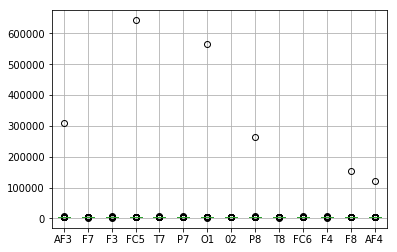

In [32]:
X.boxplot()

What do we see?

There are many approaches to outlier detection and removal. Let's use a simple one:

In [33]:
from scipy import stats

print(X.shape)
tmp = (np.abs(stats.zscore(X)) < 3).all(axis=1)
X_clean = X[tmp]
y_clean = y[tmp]
print(X_clean.shape)

(10000, 14)
(9744, 14)


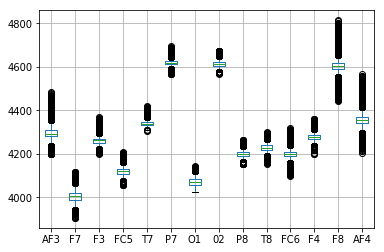

In [34]:
X_clean.boxplot()

This should look much better.

However, feature values between features are still at very different scales. We need to normalize them. 

In [35]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X_clean)
X_norm = pd.DataFrame(scaler.transform(X_clean),columns=X_clean.columns)

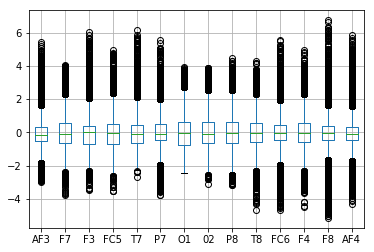

In [36]:
X_norm.boxplot()

Now each feature is at a similar scale.

Let's start with `LogisticRegression`.

In [37]:
from sklearn.linear_model import LogisticRegression

train_X, val_X, train_y, val_y = train_test_split(X_norm,y_clean,test_size=.2, random_state=random_seed)

cls_LR=LogisticRegression()
cls_LR.fit(train_X,train_y)
predictions_train = cls_LR.predict(train_X)
predictions_val = cls_LR.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

0.638614 0.635711


C:\Users\Work\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Does this perform well?

What could be the reason?

# 8. Non-linear transformations

What does linear classification mean?

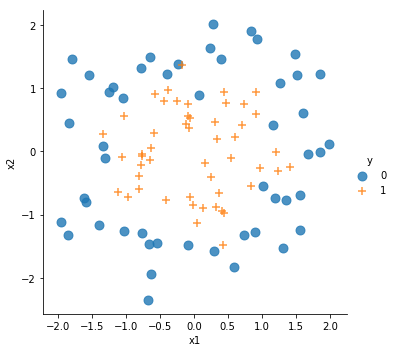

In [38]:
import seaborn as sns

dataset_tmp = pd.read_csv('svm_example1.csv')

sns.lmplot(x="x1", y="x2", data=dataset_tmp, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})

C:\Users\Work\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


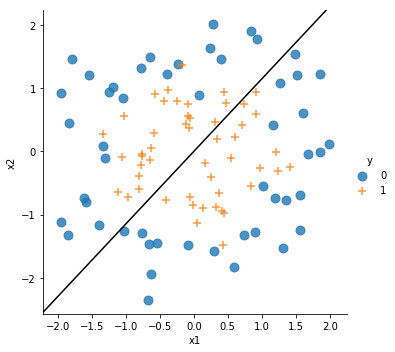

In [39]:
import imp
compomics_import = imp.load_source('compomics_import', 'compomics_import.py')

X_tmp = dataset_tmp.copy()
y_tmp = X_tmp.pop('y')

cls_LR.fit(X_tmp,y_tmp)

sns.lmplot(x="x1", y="x2", data=dataset_tmp, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
compomics_import.plot_svm_decision_function(cls_LR)

C:\Users\Work\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


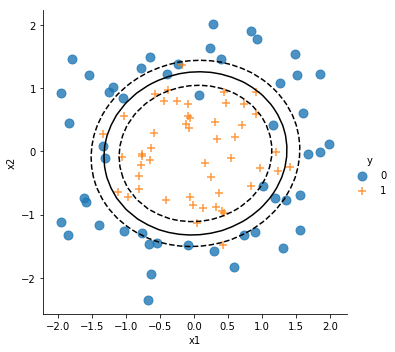

In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

polynomial_features = PolynomialFeatures(degree=2)
model = Pipeline([("polynomial_features", polynomial_features),
                         ("LR", cls_LR)])
model.fit(X_tmp,y_tmp)

sns.lmplot(x="x1", y="x2", data=dataset_tmp, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
compomics_import.plot_svm_decision_function(model)

What happens when you increase the degree?

C:\Users\Work\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


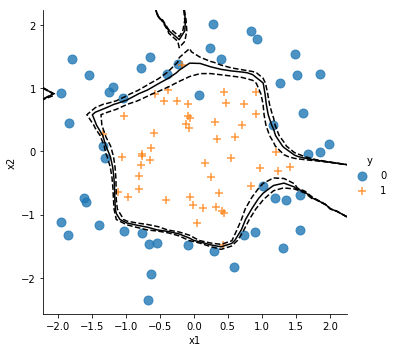

In [41]:
#solution
polynomial_features = PolynomialFeatures(degree=10)
model = Pipeline([("polynomial_features", polynomial_features),
                         ("LR", cls_LR)])
model.fit(X_tmp,y_tmp)

sns.lmplot(x="x1", y="x2", data=dataset_tmp, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
compomics_import.plot_svm_decision_function(model)

Would this work on our dataset?

In [42]:
#solution 
poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(X_norm)

train_X, val_X, train_y, val_y = train_test_split(X_poly,y_clean,test_size=.2, random_state=random_seed)

cls_LR=LogisticRegression(C=1)
cls_LR.fit(train_X,train_y)
predictions_train = cls_LR.predict(train_X)
predictions_val = cls_LR.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

C:\Users\Work\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.947530 0.935865


C:\Users\Work\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Kaggle submission?

The following code ranks the features based on the value of the hyperparameters:

In [43]:
indices = np.argsort(cls_LR.coef_[0])[::-1]
fnames = poly.get_feature_names()
for i in range(len(fnames)):
    print("%f\t%s"%(cls_LR.coef_[0][indices[i]],fnames[indices[i]]))


1.807655	x1 x10
1.470009	x0
1.418024	x3 x5
1.378798	x13
1.348768	x9
1.303823	x7 x10^2
1.274542	x0 x2
1.244254	x10 x13
1.184609	x1 x2
1.122481	x5 x6
1.115700	x3 x5 x6
1.112755	x6 x13
1.062287	x6^2
1.062241	x6 x9 x12
1.015948	x3 x9
1.012769	x4 x13
1.010332	x1 x4 x7
1.007209	x9 x10
0.995004	x4 x6 x10
0.973091	x1 x3 x6
0.939137	x0 x7
0.923033	x6 x9^2
0.902977	x1 x6 x11
0.898261	x6 x11 x12
0.897894	x1 x7 x12
0.884291	x2 x3
0.882124	x2 x6
0.845966	x6^2 x10
0.844627	x8 x10^2
0.838691	x7 x9
0.806492	x2 x3 x9
0.805961	x1 x10 x12
0.805857	x0 x3 x12
0.788045	x1^2 x4
0.773143	x6^2 x7
0.751509	x9 x12 x13
0.742888	x6 x8 x11
0.741823	x0 x5 x6
0.735112	x12^2
0.730572	x5 x6 x7
0.727317	x2
0.726824	x1 x6^2
0.718643	x1 x12
0.702116	x1 x3 x9
0.689004	x3 x7 x11
0.688997	x5^2 x13
0.686641	x1 x3
0.681797	x4 x11
0.673243	x6 x7 x12
0.659213	x7 x8^2
0.657718	x2 x8 x13
0.652726	x1 x8 x13
0.652612	x7 x9 x13
0.642408	x0 x5 x12
0.630008	x3 x6 x9
0.617016	x0 x7 x9
0.606359	x11 x12
0.606090	x2 x3 x13
0.583457	x0 x4^2

What is wrong with this code?

In [44]:
#solution
indices = np.argsort(np.abs(cls_LR.coef_[0]))[::-1]
fnames = poly.get_feature_names()
for i in range(len(fnames)):
    print("%f\t%s"%(cls_LR.coef_[0][indices[i]],fnames[indices[i]]))

1.807655	x1 x10
-1.626198	x6 x11
-1.593521	x5
1.470009	x0
1.418024	x3 x5
1.378798	x13
1.348768	x9
1.303823	x7 x10^2
1.274542	x0 x2
1.244254	x10 x13
-1.194766	x5^2
1.184609	x1 x2
1.122481	x5 x6
1.115700	x3 x5 x6
1.112755	x6 x13
-1.099969	x1 x11
-1.093884	x2 x5 x7
-1.077472	x1 x7
1.062287	x6^2
1.062241	x6 x9 x12
-1.021403	x6 x9 x13
1.015948	x3 x9
1.012769	x4 x13
1.010332	x1 x4 x7
1.007209	x9 x10
-1.005654	x1 x4^2
0.995004	x4 x6 x10
0.973091	x1 x3 x6
-0.943581	x1 x13
-0.940580	x11
-0.939702	x1 x6 x12
0.939137	x0 x7
-0.930107	x1 x6 x13
-0.928986	x1 x2^2
0.923033	x6 x9^2
-0.903893	x10 x12
0.902977	x1 x6 x11
0.898261	x6 x11 x12
0.897894	x1 x7 x12
-0.897052	x4 x10
-0.892077	x0 x1 x9
-0.891132	x7 x12
0.884291	x2 x3
0.882124	x2 x6
-0.881993	x6 x9 x11
-0.863615	x4 x6 x7
-0.856453	x9 x13
0.845966	x6^2 x10
0.844627	x8 x10^2
0.838691	x7 x9
-0.814537	x0 x1
-0.808189	x4^2 x10
0.806492	x2 x3 x9
0.805961	x1 x10 x12
0.805857	x0 x3 x12
0.788045	x1^2 x4
-0.783870	x1 x9 x11
-0.780699	x6 x7 x10
0.773143	x6^

-0.029070	x0 x9 x11
-0.028344	x0 x2 x5
0.028302	x7 x11 x12
-0.025069	x4
-0.024990	x6 x10 x13
0.024628	x9 x11^2
0.024145	x2 x10
-0.023476	x0 x8 x13
-0.022881	x0 x2 x3
0.022058	x6 x8 x9
-0.021581	x3 x5 x13
-0.020547	x2^2 x7
0.020410	x9^3
-0.020207	x5 x7 x12
0.020207	x1 x2 x13
-0.020123	x0^2 x2
0.020051	x7^2 x12
-0.019575	x1 x12 x13
0.018550	x4 x12^2
-0.018427	x2 x12
-0.016466	x1 x2 x9
0.016317	x2 x5 x9
-0.015653	x0 x11 x13
0.015105	x0 x8^2
-0.014164	x8 x11
0.013521	x0^2 x3
0.012367	x4 x6 x13
0.011309	x0 x7 x11
0.009861	x10^2
-0.008722	x2 x6 x7
-0.008502	x1 x7 x11
0.007253	x5 x6 x8
-0.007056	x4 x7^2
-0.005150	x4 x5^2
0.003650	x3 x7 x8
0.003434	x0^2 x9
-0.003110	x5 x7 x13
0.003029	x2 x5 x8
0.002876	x7 x8 x13
-0.002445	x5^2 x11
-0.002353	x0 x4 x12
0.001549	x8 x12 x13
-0.001219	x4^2 x8
-0.000998	x0 x1 x12


# 9. Support Vector Machines

Let's see what an SVM can do with an RBF kernel:

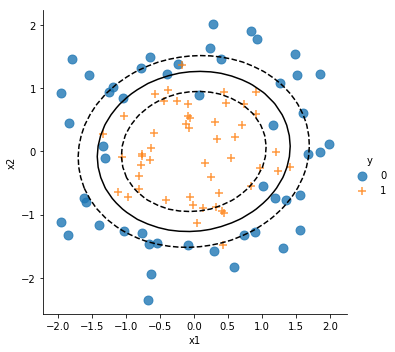

In [45]:
from sklearn.svm import SVC

model = SVC(kernel='poly',C=1,degree=2)
model.fit(X_tmp,y_tmp)

sns.lmplot(x="x1", y="x2", data=dataset_tmp, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
compomics_import.plot_svm_decision_function(model)

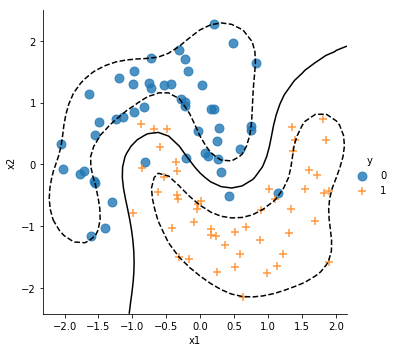

In [46]:
dataset2_tmp = pd.read_csv("svm_example2.csv")
X_tmp = dataset2_tmp.copy()
y_tmp = X_tmp.pop('y')

model = SVC(kernel='rbf',C=1,gamma=1)
model.fit(X_tmp,y_tmp)

sns.lmplot(x="x1", y="x2", data=dataset2_tmp, hue='y', markers=['o','+'], 
           fit_reg=False, height=5, scatter_kws={"s": 80})
compomics_import.plot_svm_decision_function(model)

In [47]:
train_X, val_X, train_y, val_y = train_test_split(X_norm,y_clean,test_size=.2, random_state=random_seed)

cls_SVM = SVC(kernel='rbf')
#cls_SVM = SVC(kernel='rbf', gamma=0.1, C=10)
cls_SVM.fit(train_X,train_y)
predictions_train = cls_SVM.predict(train_X)
predictions_val = cls_SVM.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

C:\Users\Work\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.903528 0.890200


# 10. Neural Networks

How about a Neural Network?

In [48]:
from sklearn.neural_network import MLPClassifier

cls_MLP=MLPClassifier(hidden_layer_sizes=(60,10))
cls_MLP.fit(train_X,train_y)
predictions_train = cls_MLP.predict(train_X)
predictions_val = cls_MLP.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

0.978833 0.952796


C:\Users\Work\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Is feature normalization required?

In [49]:
train_X, val_X, train_y, val_y = train_test_split(X,y,test_size=.2, random_state=random_seed)
cls_MLP.fit(train_X,train_y)
predictions_train = cls_MLP.predict(train_X)
predictions_val = cls_MLP.predict(val_X)
print("%f %f"%(accuracy_score(predictions_train, train_y),accuracy_score(predictions_val, val_y)))

0.495125 0.483500
